In [31]:
import numpy as np
import pandas as pd
import re
import joblib
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
import os

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GRU, SimpleRNN
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SpatialDropout1D, Activation

In [46]:
file_path = 'R-Tweets. Taras Ignatiuk.xlsx'
w2v_model_path = 'tweets_model.w2v'

data = pd.read_excel(file_path)

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [33]:
data.head(5)

,Unnamed: 0,Text,Tag,Unnamed: 3
0,0,"1. Сбербанк пережил рекордную DDoS-атаку, кото...",DDoS,1
1,1,Мы наверное не доживем до тех дней когда в Каз...,DDoS,0
2,2,RT @ru_pirateparty: Руководство Сбербанка сооб...,DDoS,0
3,3,RT @ServerNews_RU: Роскомнадзор: с февраля мощ...,DDoS,1
4,4,Работают в две смены? Хакеры рекордно долго ат...,DDoS,1


In [34]:
data.rename(columns = {data.columns[3]: 'Label'}, inplace = True)

In [35]:
data.head(5)

,Unnamed: 0,Text,Tag,Label
0,0,"1. Сбербанк пережил рекордную DDoS-атаку, кото...",DDoS,1
1,1,Мы наверное не доживем до тех дней когда в Каз...,DDoS,0
2,2,RT @ru_pirateparty: Руководство Сбербанка сооб...,DDoS,0
3,3,RT @ServerNews_RU: Роскомнадзор: с февраля мощ...,DDoS,1
4,4,Работают в две смены? Хакеры рекордно долго ат...,DDoS,1


In [36]:
print(data['Label'].value_counts())

0    902
2    129
1    106
Name: Label, dtype: int64


In [37]:
russian_stopwords = set(stopwords.words('russian'))

In [38]:
def preprocess_text_russian(text):
    text = re.sub(r"http\s+|www\s+|https\s", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^А-Яа-яёЁ ]+', '', text)
    text = text.lower()
    tokens = word_tokenize(text, language ='russian')
    tokens = [word for word in tokens if word not in russian_stopwords]
    return ' '.join(tokens)

In [39]:
data['cleaned_data'] = data['Text'].apply(preprocess_text_russian)

In [40]:
data.head(5)

,Unnamed: 0,Text,Tag,Label,cleaned_data
0,0,"1. Сбербанк пережил рекордную DDoS-атаку, кото...",DDoS,1,сбербанк пережил рекордную атаку которую прове...
1,1,Мы наверное не доживем до тех дней когда в Каз...,DDoS,0,наверное доживем тех дней казахстане появится ...
2,2,RT @ru_pirateparty: Руководство Сбербанка сооб...,DDoS,0,руководство сбербанка сообщило крупнейшей атаке
3,3,RT @ServerNews_RU: Роскомнадзор: с февраля мощ...,DDoS,1,роскомнадзор февраля мощность атак россию выро...
4,4,Работают в две смены? Хакеры рекордно долго ат...,DDoS,1,работают две смены хакеры рекордно долго атако...


In [41]:
max_words = 5000
max_len = 100

In [42]:
X = data['cleaned_data'].tolist()
y = data['Label'].values

In [43]:
tokenizer = Tokenizer(num_words = max_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen = max_len, padding = 'post')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.2, random_state = 42)

In [45]:
import gensim

NUM = 100000

from gensim.models import Word2Vec

# Load or train the Word2Vec model
if os.path.exists(w2v_model_path):
    print("Loading pre-trained Word2Vec model...")
    w2v_model = Word2Vec.load(w2v_model_path)
else:
    print("Training new Word2Vec model...")
    tokenized_texts = [text.split() for text in X]  # Tokenize each tweet into words
    w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=300, window=5, min_count=1, workers=4)
    w2v_model.save(w2v_model_path)

embedding_dim = w2v_model.vector_size

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# Fill the embedding matrix
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.key_to_index:  # Updated for gensim 4.x
        embedding_matrix[i] = w2v_model.wv[word]


Loading pre-trained Word2Vec model...


In [45]:
num_classes = len(np.unique(y))

model_RNN = Sequential([
    Embedding(input_dim = len(tokenizer.word_index) + 1, 
             output_dim = embedding_dim,
             weights = [embedding_matrix],
             input_length = max_len,
             trainable = True),
    Bidirectional(SimpleRNN(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(128, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences = False, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])

model_RNN.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.005),
                 metrics = ['accuracy'])
model_RNN.build(input_shape = (None, max_len))
model_RNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 200)            │       1,119,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100, 128)            │          33,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100, 256)            │         124,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,343,979 (5.13 MB)

 Trainable params: 1,343,979 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history_RNN = model_RNN.fit(X_train, y_train, epochs = 50, batch_size = 32,
                           validation_data = (X_test, y_test))

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 333ms/step - accuracy: 0.7114 - loss: 3.2063 - val_accuracy: 0.7939 - val_loss: 0.6907
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.8150 - loss: 0.7028 - val_accuracy: 0.8553 - val_loss: 0.6467
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.8502 - loss: 0.5813 - val_accuracy: 0.8289 - val_loss: 0.8186
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.8685 - loss: 0.6666 - val_accuracy: 0.8772 - val_loss: 0.7055
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.9392 - loss: 0.5123 - val_accuracy: 0.8596 - val_loss: 0.6554
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.9649 - loss: 0.4544 - val_accuracy: 0.9079 - val_loss: 0.6415
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.9665 - loss: 0.3288 - val_accuracy: 0.8377 - val_loss: 0.6464
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.9636 - loss: 0.3405 - val_accuracy: 

In [47]:
import pickle

with open('Russian_history_RNN.pkl', 'wb') as f:
    pickle.dump(history_RNN.history, f)

In [48]:
with open('Russian_history_RNN.pkl', 'rb') as f:
    loaded_RNN_history = pickle.load(f)

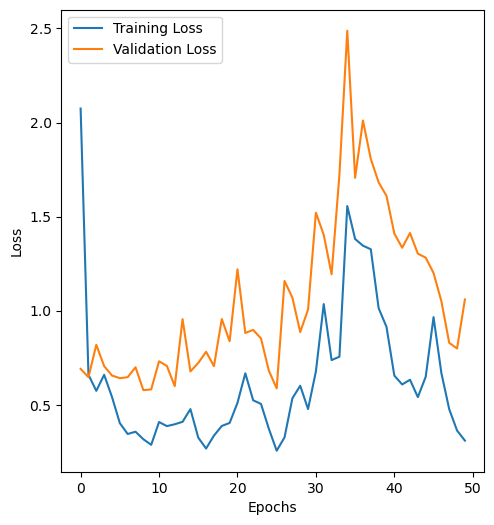

In [49]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(loaded_RNN_history['loss'], label = 'Training Loss')
plt.plot(loaded_RNN_history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

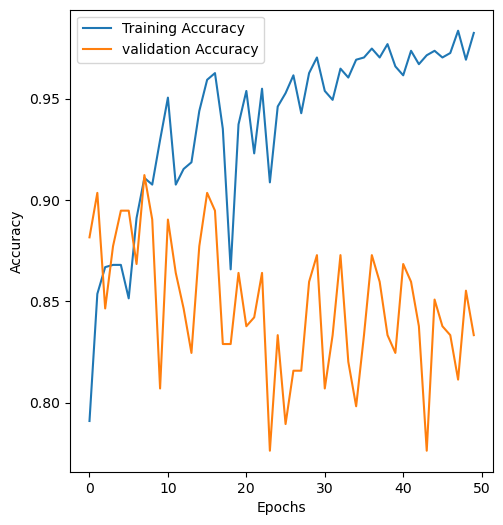

In [44]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
plt.plot(loaded_RNN_history['accuracy'], label = 'Training Accuracy')
plt.plot(loaded_RNN_history['val_accuracy'], label =  'validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [50]:
num_classes = len(np.unique(y))
model_lstm = Sequential([
    Embedding(input_dim = len(tokenizer.word_index) +1, output_dim = embedding_dim,
             weights = [embedding_matrix],
             input_length = max_len,
             trainable = True),
    Bidirectional(LSTM(128, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(128, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(32, return_sequences = False, kernel_regularizer = l2(0.01))),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])
model_lstm.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])
model_lstm.build(input_shape= (None, max_len))
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 200)            │       1,119,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 100, 256)            │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 100, 128)            │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,572,107 (6.00 MB)

 Trainable params: 1,572,107 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history_lstm = model_lstm.fit(X_train, y_train,
                             epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 356ms/step - accuracy: 0.7418 - loss: 9.7297 - val_accuracy: 0.8132 - val_loss: 7.5175
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.7811 - loss: 7.0499 - val_accuracy: 0.8242 - val_loss: 5.4841
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.7889 - loss: 5.2081 - val_accuracy: 0.8846 - val_loss: 4.0208
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.8919 - loss: 3.7364 - val_accuracy: 0.9066 - val_loss: 3.0062
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9332 - loss: 2.7974 - val_accuracy: 0.8681 - val_loss: 2.4448
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.9209 - loss: 2.2071 - val_accuracy: 0.9066 - val_loss: 1.9148
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.9495 - loss: 1.7258 - val_accuracy: 0.9451 - val_loss: 1.5326
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.9652 - loss: 1.3556 - val_accuracy: 0

In [54]:
import pickle

with open('Russian_history_LSTM.pkl', 'wb') as f:
    pickle.dump(history_lstm.history, f)

In [55]:
with open('Russian_history_LSTM.pkl', 'rb') as f:
    loaded_LSTM_history = pickle.load(f)

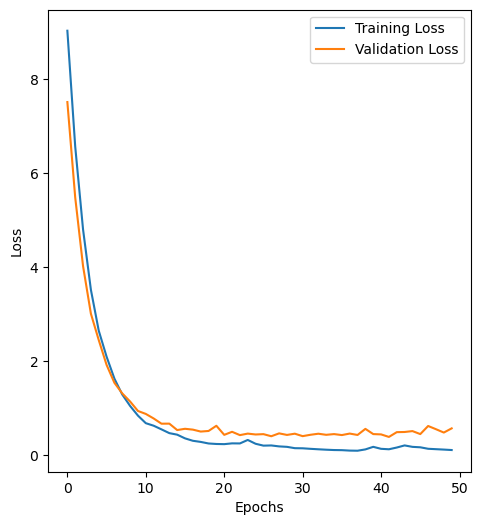

In [56]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(loaded_LSTM_history['loss'], label = 'Training Loss')
plt.plot(loaded_LSTM_history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

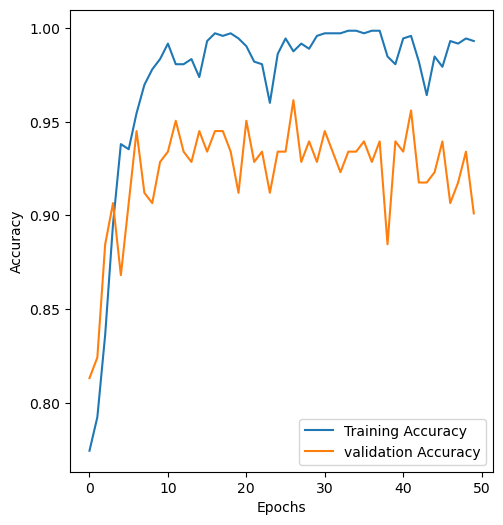

In [57]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
plt.plot(loaded_LSTM_history['accuracy'], label = 'Training Accuracy')
plt.plot(loaded_LSTM_history['val_accuracy'], label =  'validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [58]:
num_classes = len(np.unique(y))

model_GRU = Sequential([
    Embedding(input_dim = len(tokenizer.word_index)+1,
             output_dim = embedding_dim,
             weights = [embedding_matrix],
             input_length = max_len,
             trainable = True),
    Bidirectional(GRU(128, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(32, return_sequences = False, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])

model_GRU.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.001),
                 metrics = ['accuracy'])
model_GRU.build(input_shape = (None, max_len))
model_GRU.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 200)            │       1,119,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 100, 256)            │         253,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 100, 128)            │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 64)                  │          12,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,437,675 (5.48 MB)

 Trainable params: 1,437,675 (5.48 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
history_GRU = model_GRU.fit(X_train, y_train, validation_data = (X_test, y_test),
                           epochs = 50,
                           batch_size = 32)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 390ms/step - accuracy: 0.6034 - loss: 7.1260 - val_accuracy: 0.7939 - val_loss: 3.9972
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.7908 - loss: 3.5488 - val_accuracy: 0.8684 - val_loss: 2.0439
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.8780 - loss: 1.7685 - val_accuracy: 0.8728 - val_loss: 1.2498
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.9189 - loss: 1.0488 - val_accuracy: 0.8947 - val_loss: 0.9447
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.9551 - loss: 0.6894 - val_accuracy: 0.9123 - val_loss: 0.7537
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9569 - loss: 0.5167 - val_accuracy: 0.8947 - val_loss: 0.7062
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.9729 - loss: 0.3904 - val_accuracy: 0.8904 - val_loss: 0.6575
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 0.9876 - loss: 0.3023 - val_accuracy: 0

In [ ]:
with open('gru_Russian_history.pkl', 'wb') as f:
    pickle.dump(history_GRU.history, f)

In [ ]:
with open('gru_Russian_history.pkl', 'rb') as f:
    loaded_GRU_history = pickle.load(f)

In [ ]:
plt.figure(figsize =(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loaded_GRU_history['loss'], label = 'Training Loss')
plt.plot(loaded_GRU_history['val_accuracy'], label = 'Validaiton Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
plt.figure(figsize = (10,6))
plt.subplot(1, 2, 2)
plt.plot(loaded_GRU_history['accuracy'], label = 'Training Accuracy')
plt.plot(loaded_GRU_history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()